## Non-holonomic RRT 

In [44]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import random
import math
import itertools

In [52]:
class Env:
    def __init__(self, obst_x, obst_y, num_rects, circle_x, circle_y, radii, num_circles, xmin, xmax, ymin, ymax):
        self.obst_x = obst_x
        self.obst_y = obst_y
        self.num_rects = num_rects
        self.circle_x = circle_x
        self.circle_y = circle_y
        self.radii = radii
        self.num_circles = num_circles
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
    def in_env(self, x, y):
        if (x >= self.xmin) and (x <= self.xmax) and (y >= self.ymin) and (y <= self.ymax):
            return True
        return False
        
    def in_circle(self, i, x, y):
        if ((self.circle_x[i] - x)**2 + (self.circle_y[i] - y)**2 <= self.radii[i]**2):
            return True
        return False
    
    def in_rect(self, i, x, y):
        rect_xmin, rect_ymin = self.obst_x[4*i], self.obst_y[4*i]
        rect_xmax, rect_ymax = self.obst_x[4*i+2], self.obst_y[4*i+2]
        
        if (x >= rect_xmin) and (x <= rect_xmax) and (y >= rect_ymin) and (y <= rect_ymax):
            return True
        return False
        
    def edge_in_rect(self, i, x1, y1, x2, y2):
        rect_xmin, rect_ymin = self.obst_x[4*i], self.obst_y[4*i]
        rect_xmax, rect_ymax = self.obst_x[4*i+2], self.obst_y[4*i+2]
        
        for part in range(101):
            ratio = part / 100
            x = x1*ratio + x2*(1-ratio)
            y = y1*ratio + y2*(1-ratio)
            
            if (x >= rect_xmin) and (x <= rect_xmax) and (y >= rect_ymin) and (y <= rect_ymax):
                return True
            
        return False
    
    def is_free(self, x, y):
        for i in range(self.num_rects):
            if self.in_rect(i, x, y):
                return False
            
        for i in range(self.num_circles):
            if self.in_circle(i, x, y):
                return False
        
        return True
    
    def edge_is_free(self, x1, y1, x2, y2):
        for i in range(self.num_rects):
            if self.edge_in_rect(i, x1, y1, x2, y2):
                return False
            
        return True

In [63]:
class nonhn_RRT:
    def __init__(self,start_config,goal,v_init,w_init, env):
        (x0,y0,theta0) = start_config
        self.xg = goal[0]
        self.yg = goal[1]
        self.x = []
        self.y = []
        self.theta = []
        self.x.append(x0)
        self.y.append(y0)
        self.theta.append(theta0)
        self.vc = [] #platform centre v list
        self.wc = [] #platform centre w list
        self.vc.append(v_init)
        self.wc.append(w_init)
        self.env = env
        self.parent = []
        self.path_v_list = []
        self.path_w_list = []
        self.parent.append(0)
        
    # implement non-holonomic RRT to find platform centre velocities
    
    def get_dist(self, n1, n2):
        x1, y1 = self.x[n1], self.y[n1]
        x2, y2 = self.x[n2], self.y[n2]
        
        return ((x1-x2)**2 + (y1-y2)**2)**0.5
    
    def random_node(self):
        xt = random.uniform(self.env.xmin, self.env.xmax)
        yt = random.uniform(self.env.ymin, self.env.ymax)
        thetat = random.uniform(-math.pi, math.pi)
        
        n = len(self.x)
        self.add_node(xt, yt, thetat, 0, 0)
        near_node = self.find_near_node(n)
        xf, yf, thetaf, vf, wf = self.drive(near_node, n)
        
        if self.env.in_env(xf, yf):
            self.remove_node(n)
            self.add_node(xf, yf, thetaf, vf, wf)
            
            if self.env.is_free(xf, yf):
                self.step(near_node, n, thetat, vf, wf)
                
                if self.env.edge_is_free(xf, yf, self.x[near_node], self.y[near_node]):
                    self.add_edge(near_node, n)
                else:
                    self.remove_node(n)
            else:
                self.remove_node(n)
        
        else:
            self.remove_node(n)
            
    def find_near_node(self, n):
        min_dist = self.get_dist(0, n)
        near_node = 0
        for i in range(1, n):
            dist = self.get_dist(i, n)
            if dist < min_dist:
                min_dist = dist
                near_node = i
        
        return near_node
    
    def drive(self, nn, n):
        xi, yi, thetai = self.x[nn], self.y[nn], self.theta[nn]
        xg, yg, thetag = self.x[n], self.y[n], self.theta[n]
        
        v, w = [0.5, 6], [-math.pi/10, 0, math.pi/10]
        controls = list(itertools.product(v, w))
        
        min_dist = np.inf
        xf, yf, thetaf, vf, wf = 0, 0, 0, 0, 0
        
        for cont in controls:
            vt, wt = cont
            xt = xi + vt * math.cos(thetai + wt)
            yt = yi + vt * math.sin(thetai + wt)
            
            dist_goal = ((xt - xg)**2 + (yt - yg)**2)**0.5
            
            if dist_goal < min_dist:
                xf, yf, thetaf, vf, wf = xt, yt, thetai + wt, vt, wt
                min_dist = dist_goal
        
        return xf, yf, thetaf, vf, wf
        
    def add_node(self, x, y, theta, v, w):
        self.x.append(x)
        self.y.append(y)
        self.theta.append(theta)
        self.vc.append(v)
        self.wc.append(w)
        
    def remove_node(self, n):
        self.x.pop(n)
        self.y.pop(n)
        self.theta.pop(n)
        self.vc.pop(n)
        self.wc.pop(n)
        
    def add_edge(self, parent, child):
        self.parent.insert(child, parent)
        
    def remove_edge(self, n):
        self.parent.pop(n)
        
    def step(self, nn, n, theta, v, w):
        dist = self.get_dist(nn, n)
        
        if dist > 10:
            u = 10 / d
            xnn, ynn = self.x[nn], self.y[nn]
            xn, yn = self.x[n], self.y[n]
            px, py = xn-xnn, yn-ynn
            
            theta_des = self.theta[nn] + w
            x, y = xnn+b*math.cos(theta_des), ynn+v*math.sin(theta_des)
            self.remove_node(n)
            self.add_node(x, y, theta, v, w)
            
    def clear(self, start_config):
        (x0,y0,theta0) = start_config
        self.x = []
        self.y = []
        self.theta = []
        self.x.append(x0)
        self.y.append(y0)
        self.theta.append(theta0)
        self.parent = []
        self.parent.append(0)
        
    def goal_path(self):
        tol = 5
        self.goal_node = len(self.x)-1
        for i in range(len(self.x)):
            x, y = self.x[i], self.y[i]
            if ((x - self.xg)**2 + (y - self.yg)**2)**0.5 < tol:
                self.goal_node = i
                break
                
        self.path = [self.goal_node]
        par_node = self.parent[self.goal_node]
        while par_node != 0:
            self.path.append(par_node)
            par_node = self.parent[par_node]
        
        self.path.append(0)
    
    def showpath(self):
        """
        Create a new directory (say nonholonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """ 
        n = len(self.path)-1
        for i in range(n):
            n1 = self.path[n-i]
            n2 = self.path[n-i-1]
            self.path_v_list.append((self.vc[n2]))
            self.path_w_list.append((self.wc[n2]))
            
            plt.plot([self.x[n1], self.x[n2]], [self.y[n1], self.y[n2]], 'bo-', lw=1, markersize=3)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.savefig('nonholonomic_path/snap%s.png'%str(i), dpi = 200)
                    
    def showtree(self):
        """
        Create a new directory (say nonholonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        for i in range(len(self.x)):
            par = self.parent[i]
            plt.plot([self.x[i], self.x[par]], [self.y[i], self.y[par]], '0.15', lw=0.5)
            plt.gca().set_aspect('equal', adjustable='box')
            if i % 20 == 0:
                plt.savefig('nonholonomic_tree/snap%s.png'%str(i//20+1), dpi=200)
        
    def test_env(self):
        """
        Function to generate test environment
        """
        plt.plot(self.xg,self.yg,'g*',markersize=20)
        plt.plot(self.x[0],self.y[0],'b*',markersize=20)
        
        for i in range(self.env.num_rects):
            x = self.env.obst_x[4*i]
            y = self.env.obst_y[4*i]
            width = self.env.obst_x[4*i+2] - self.env.obst_x[4*i]
            height = self.env.obst_y[4*i+2] - self.env.obst_y[4*i]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)

        for i in range(self.env.num_circles):
            circle = plt.Circle((self.env.circle_x[i], self.env.circle_y[i]),radii[i], color='r')
            plt.gca().add_patch(circle)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        
    def draw(self):
        plt.plot(self.xg,self.yg,'g*',markersize=20)
        plt.plot(self.x[0],self.y[0],'b*',markersize=20)
        
        for i in range(self.env.num_rects):
            x = self.env.obst_x[4*i]
            y = self.env.obst_y[4*i]
            width = self.env.obst_x[4*i+2] - self.env.obst_x[4*i]
            height = self.env.obst_y[4*i+2] - self.env.obst_y[4*i]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)

        for i in range(self.env.num_circles):
            circle = plt.Circle((self.env.circle_x[i], self.env.circle_y[i]),radii[i], color='r')
            plt.gca().add_patch(circle)
        
        self.showtree()
        self.showpath()
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

## Set 1

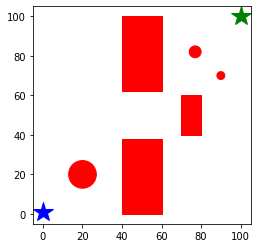

In [54]:
obst_vertex_x = [40,40,60,60,70,70,80,80,40,40,60,60]
obst_vertex_y = [62,100,100,62,40,60,60,40, 0,38,38, 0]
circle_x = [20,90,77]
circle_y = [20,70,82]
radii = [7,2,3]
num_circles = 3
num_rects = 3
env = Env(obst_vertex_x, obst_vertex_y, num_rects, circle_x, circle_y, radii, num_circles, 0, 100, 0, 100)
        
goal = (100,100)
start_config =(0,1,0)
vinit = 5
winit = 0.1
nn_RRT = nonhn_RRT(start_config,goal,vinit,winit, env)
nn_RRT.test_env()

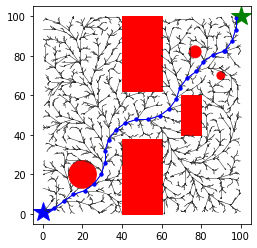

In [55]:
for i in range(10000):
    nn_RRT.random_node()
    
nn_RRT.goal_path()
nn_RRT.draw()

In [77]:
def visualize_wheels(vc,wc):
    """
    Given the list of platform centre velocities(v,w) visualize the trajectories of:
    1. platform centre
    2. left wheel
    3. right wheel
    
    Save the wheel trajectories in the same manner that we saved the snapshots of the RRT tree above.
    """
    
    b = 1.5
    lw_x, lw_y, rw_x, rw_y, c_x, c_y, t = [start_config[0]], [start_config[1]+b], [start_config[0]], [start_config[1]-b], [start_config[0]], [start_config[0]], [start_config[2]]
    lw_v, rw_v = [], []
    
    for i in range(len(wc)):
        lw_v.append(vc[i] - b * wc[i])
        rw_v.append(vc[i] + b * wc[i])
        
    for i in range(len(lw_v)):
        t_c = t[-1] + wc[i]
        c_x_c = c_x[-1] + vc[i] * np.cos(t_c)
        c_y_c = c_y[-1] + vc[i] * np.sin(t_c)
        
        lw_x_c = c_x_c - b * np.sin(t_c)
        lw_y_c = c_y_c + b * np.cos(t_c)
        rw_x_c = c_x_c + b * np.sin(t_c)
        rw_y_c = c_y_c - b * np.cos(t_c)
        
        t.append(t_c)
        lw_x.append(lw_x_c)
        lw_y.append(lw_y_c)
        rw_x.append(rw_x_c)
        rw_y.append(rw_y_c)
        c_x.append(c_x_c)
        c_y.append(c_y_c)
        
    for j in range(len(lw_y)):
        plt.plot(goal[0],goal[1],'g*',markersize=20)
        plt.plot(start_config[0],start_config[1],'b*',markersize=20)
        
        for i in range(num_rects):
            x = obst_vertex_x[4*i]
            y = obst_vertex_y[4*i]
            width = obst_vertex_x[4*i+2] - obst_vertex_x[4*i]
            height = obst_vertex_y[4*i+2] - obst_vertex_y[4*i]
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)

        for i in range(num_circles):
            circle = plt.Circle((circle_x[i], circle_y[i]),radii[i], color='r')
            plt.gca().add_patch(circle)
        
        plt.plot(lw_x[:j], lw_y[:j], 'r--')
        plt.plot(rw_x[:j], rw_y[:j], 'b--')
        plt.plot(c_x[:j], c_y[:j], 'k-')
        colors = ['red', 'blue']
        lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
        labels = ['left wheel', 'right wheel']
        plt.legend(lines, labels)
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.savefig('nonholonomic_wheel/snap%s.png'%str(j))

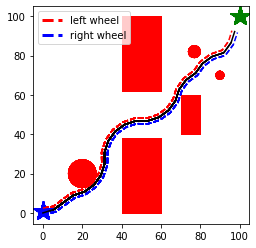

In [78]:
visualize_wheels(nn_RRT.path_v_list, nn_RRT.path_w_list)

## Set 2

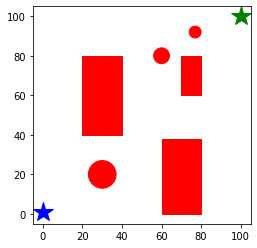

In [87]:
obst_vertex_x = [20,20,40,40,70,70,80,80,60,60,80,80]
obst_vertex_y = [40,80,80,40,60,80,80,60, 0,38,38, 0]
circle_x = [30,60,77]
circle_y = [20,80,92]
radii = [7,4,3]
num_circles = 3
num_rects = 3
env = Env(obst_vertex_x, obst_vertex_y, num_rects, circle_x, circle_y, radii, num_circles, 0, 100, 0, 100)
        
goal = (100,100)
start_config =(0,1,0)
vinit = 5
winit = 0.1
nn_RRT = nonhn_RRT(start_config,goal,vinit,winit, env)
nn_RRT.test_env()

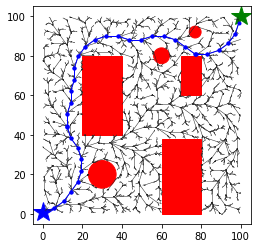

In [88]:
for i in range(10000):
    nn_RRT.random_node()
    
nn_RRT.goal_path()
nn_RRT.draw()

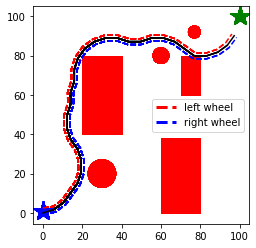

In [89]:
visualize_wheels(nn_RRT.path_v_list, nn_RRT.path_w_list)